In [1]:
import base64
import pandas as pd
from dotenv import load_dotenv
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
#from langchain_openai import OpenAIEmbeddings
from langchain_openai import AzureOpenAI
from langchain_openai import AzureOpenAIEmbeddings
import io
import re
import base64
from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
#from langchain.chat_models import ChatOpenAI
from langchain_openai import AzureChatOpenAI
from langchain.schema import HumanMessage
#from langchain.output_parsers import StrOutputParser
from PIL import Image
import os

In [1]:

root = os.path.dirname(os.path.realpath(''))
data = os.path.join(root,'Data')

In [2]:
image_path = os.path.join(data,'sample_image')
#image_path

In [4]:
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def load_metadata(csv_path):
    """Load metadata from CSV file"""
    return pd.read_csv(csv_path)

def get_combined_text_for_image(img_file, metadata_df):
    """Retrieve combined_text for a specific image based on isic_id"""
    # Extract the isic_id from the image filename (assuming it's the part before the file extension)
    isic_id = os.path.splitext(img_file)[0]  # This removes the '.jpg' extension

    # Find the row in the DataFrame where isic_id matches
    row = metadata_df[metadata_df['isic_id'] == isic_id]
    
    if not row.empty:
        return row['combined_text'].values[0]  # Extract the combined_text value
    else:
        return ""


def generate_img_data(path, csv_path):
    """
    Generate base64 encoded strings and metadata for images
    path: Path to the directory with .jpg files
    csv_path: Path to the CSV file with metadata
    """

    # Load metadata from CSV
    metadata_df = load_metadata(csv_path)

    # Store base64 encoded images
    img_base64_list = []

    # Store image metadata
    image_metadata_list = []

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            
            # Get combined_text for the image
            combined_text = get_combined_text_for_image(img_file, metadata_df)
            image_metadata_list.append(combined_text)

    return img_base64_list, image_metadata_list

In [5]:
# Paths
image_directory = image_path  # Replace with the path to your images
csv_file_path = "Merged_Data1.csv"  # Replace with the path to your CSV

# Generate base64 encoded images and retrieve combined_text metadata
img_base64_list,  image_summaries = generate_img_data(image_directory, csv_file_path)

# Now img_base64_list contains base64-encoded images and image_metadata_list contains the corresponding combined_text for each image.


In [6]:
pd.read_csv('Merged_Data1.csv')

,isic_id,combined_text
0,ISIC_9153490,ISIC_9153490 0 60.0 male upper extremity 2.6 T...
1,ISIC_0157465,ISIC_0157465 0 55.0 female upper extremity 3.3...
2,ISIC_6306355,ISIC_6306355 0 65.0 male posterior torso 6.05 ...
3,ISIC_2358370,ISIC_2358370 0 85.0 male anterior torso 2.52 T...
4,ISIC_1565789,ISIC_1565789 0 65.0 male anterior torso 3.1 TB...
...,...,...
95,ISIC_2364514,ISIC_2364514 1 50.0 male upper extremity 14.03...
96,ISIC_1071408,ISIC_1071408 1 60.0 male anterior torso 9.73 T...
97,ISIC_7800702,ISIC_7800702 1 65.0 male head/neck 4.9 TBP til...
98,ISIC_3005303,ISIC_3005303 1 80.0 male anterior torso 5.18 T...


In [7]:
len(img_base64_list)

100

In [8]:
len(image_summaries)

100

In [9]:
image_summaries[89]

'ISIC_9153490 0 60.0 male upper extremity 2.6 TBP tile: close-up 3D: XP 21.00771 18.01633 30.21897 29.32878 36.80367 34.42042 55.19364 58.43807 34.15388 40.1036 2.852318 18.55894 0.08117166 2.991376 0.890193 -5.949719 6.092942 5.71841 0.8189265 Right Arm - Lower Right Arm 1.506849 0.04638791 4.223213 0.2035441 7.275712 0.05515234 1.081774 1.793079 0.4226804 10 432.8594 1247.562 0.8339233 Department of Dermatology, Hospital Clínic de Barcelona CC-BY-NC benign'

In [11]:


#os.environ["OPENAI_API_VERSION"] = OPENAI_API_VERSION
os.environ["OPENAI_API_TYPE"] = OPENAI_API_TYPE
os.environ["OPENAI_API_BASE"] = OPENAI_API_BASE
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
load_dotenv

<function dotenv.main.load_dotenv(dotenv_path: Union[str, ForwardRef('os.PathLike[str]'), NoneType] = None, stream: Optional[IO[str]] = None, verbose: bool = False, override: bool = False, interpolate: bool = True, encoding: Optional[str] = 'utf-8') -> bool>

In [13]:


def create_multi_vector_retriever(vectorstore, image_summaries, images, text_summaries=None, texts=None):
    """
    Create retriever that indexes summaries, but returns raw images or texts.
    """
    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add images and their corresponding summaries
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    # Add texts and their corresponding summaries (optional)
    if text_summaries and texts:
        add_documents(retriever, text_summaries, texts)

    return retriever

# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_skincancer_db", embedding_function=AzureOpenAIEmbeddings()
)

# Assume image_metadata_list is the list of metadata (combined_texts) corresponding to each image
# Assume img_base64_list is the list of base64-encoded images
image_summaries = image_summaries # Using metadata as summaries

In [14]:
AzureOpenAIEmbeddings()

AzureOpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x00000233FD2EE120>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x00000233FD34D550>, model='text-embedding-ada-002', dimensions=None, deployment=None, openai_api_version='2023-05-15', openai_api_base=None, openai_api_type='Azure', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=2048, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True, azure_endpoint='https://dp-openai-v3.openai.azure.com/', azure_ad_token=None, azure_ad_token_provider=None, validate_base_url=True)

In [15]:
# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    image_summaries=image_summaries,
    images=img_base64_list
)

In [16]:
retriever_multi_vector_img

MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000233FCE7DB20>, docstore=<langchain_core.stores.InMemoryStore object at 0x00000233FD14BF80>)

In [17]:
#%pip install -qU langchain-openai

In [18]:


def plt_img_base64(img_base64):
    """Display base64 encoded string as image"""
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    is_base64 = re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None
    #print(f"looks_like_base64({sb[:30]}...): {is_base64}")
    return is_base64


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

def resize_base64_image(base64_string, size=(256, 256)):
    """
    Resize an image encoded as a Base64 string to a size more appropriate for analysis
    """
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(256, 256))  # Adjusted size for skin analysis
            b64_images.append(doc)
        else:
            texts.append(doc)
            #print(texts)
    return {"images": b64_images, "texts": texts}



def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    #print(data_dict)
    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are a medical expert specializing in skin cancer detection.\n"
            "You are given a mixture of text data and dermatoscopic images to train on.\n"
            "Use this information to predict whether its a begnin or malignant case on new input text data.\n"
            f"User-provided query: {data_dict['question']}\n\n"
            "Relevant medical texts and notes:\n"
            f"{formatted_texts}"
            "No analysis is required. Just give the prediction in terms of probability"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """
    # Multi-modal LLM
    #model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)
    model = AzureChatOpenAI(
                azure_deployment="skincancer-final-model",  # or your deployment
                api_version="2023-06-01-preview",  # or your api version
                temperature=0,
                max_tokens=None,
                timeout=None,
                max_retries=2,
                # other params...
            )

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | RunnableLambda(lambda x: x.content)  # Parsing output to string
    )

    return chain

from langchain_openai import AzureChatOpenAI



# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)


In [21]:
"""test_docs = [
    "45	male anterior torso	16.45 TBP tile: close-up 3D: XP	10.04022 13.80461 12.19361 24.57513	15.79526 28.18695 50.53194 6.67573	17.63536 41.38646 93.97636 20.48454	4.569612 -3.764385 -12.38152 -23.7511 26.91705 25.49814	0.8977018 Torso Front Bottom Half Torso Front 7.534248 2.73E-07	2.913925 10	43.87554 5.375057 9.30981 2.464056	0.1985481 155 -182.8401	1106.817 37.00763 Department of Dermatology, Hospital ClÃ­nic de Barcelona	CC-BY-NC",
    encode_image(image_path+ "\\ISIC_1211710.jpg")
]

split_result = split_image_text_types(test_docs)
print("Resulting split:", split_result)"""


'test_docs = [\n    "45\tmale anterior torso\t16.45 TBP tile: close-up 3D: XP\t10.04022 13.80461 12.19361 24.57513\t15.79526 28.18695 50.53194 6.67573\t17.63536 41.38646 93.97636 20.48454\t4.569612 -3.764385 -12.38152 -23.7511 26.91705 25.49814\t0.8977018 Torso Front Bottom Half Torso Front 7.534248 2.73E-07\t2.913925 10\t43.87554 5.375057 9.30981 2.464056\t0.1985481 155 -182.8401\t1106.817 37.00763 Department of Dermatology, Hospital ClÃ\xadnic de Barcelona\tCC-BY-NC",\n    encode_image(image_path+ "\\ISIC_1211710.jpg")\n]\n\nsplit_result = split_image_text_types(test_docs)\nprint("Resulting split:", split_result)'

In [22]:
chain_multimodal_rag

{
  context: MultiVectorRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000233FCE7DB20>, docstore=<langchain_core.stores.InMemoryStore object at 0x00000233FD14BF80>)
           | RunnableLambda(split_image_text_types),
  question: RunnablePassthrough()
}
| RunnableLambda(img_prompt_func)
| AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000023380299040>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000233FEA56C60>, root_client=<openai.lib.azure.AzureOpenAI object at 0x00000233801F43B0>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000023380299070>, temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='', azure_endpoint='https://dp-openai-v3.openai.azure.com/', deployment_name='skincancer-final-model', openai_api_version='2023-06-01-preview', openai_api_type='Azure')
| RunnableLambda(...)

In [27]:
# Check retrieval with a query relevant to skin cancer detection
#query = "Identify signs of malignant in these images and correlate with the provided textual descriptions. Consider features like asymmetry, border irregularity, color variation, and diameter."
#query = 'Retrieve some sample images for malignant cases and text description related to it'
query = "ISIC_0074664 0 IP_9179679 70 male posterior torso 3.01 TBP tile: close-up 3D: XP 21.38496 16.90438 30.64639 29.90155 37.37001 34.3491 55.09278 60.51902 35.67091 44.6079 4.034528 17.5092 1.624217 4.480578 0.7448426 -8.936993 9.2946 7.969639 0.8523205 Torso Back Middle Third Torso Back 1.726028 62.32678 4.059123 4.634695 8.404841 1.471253 4.310717 1.789126 0.4263566 50 64.70935 1220.591 172.2924 Department of Dermatology, Hospital Clínic de Barcelona CC-BY-NC"
# Retrieve documents using the multi-vector retriever
docs = retriever_multi_vector_img.invoke(query, limit=6)

# Check the number of retrieved documents
len(docs)


4


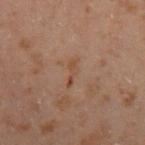

In [28]:
# We get back relevant images
plt_img_base64(docs[0])

In [29]:
#RAG
#Now let's run RAG and test the ability to synthesize an answer to our question.

# Run RAG chain
output = chain_multimodal_rag.invoke(query)

looks_like_base64(/9j/4AAQSkZJRgABAQAAAQABAAD/2w...): True
looks_like_base64(/9j/4AAQSkZJRgABAQAAAQABAAD/2w...): True
looks_like_base64(/9j/4AAQSkZJRgABAQAAAQABAAD/2w...): True
looks_like_base64(/9j/4AAQSkZJRgABAQAAAQABAAD/2w...): True
{'context': {'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJm

In [30]:
print(output)

Based on the provided data and the context of skin cancer detection, the prediction for whether the case is benign or malignant is as follows:

**Probability of being malignant: 0.70 (70%)**

This prediction is derived from the given information, including the dermatoscopic images and the textual data provided.


In [153]:
new_query = 'Tell me what you think from this text data whether it is a malignant or benign case ISIC_0074664  IP_9179679 70 male posterior torso 3.01 TBP tile: close-up 3D: XP 21.38496 16.90438 30.64639 29.90155 37.37001 34.3491 55.09278 60.51902 35.67091 44.6079 4.034528 17.5092 1.624217 4.480578 0.7448426 -8.936993 9.2946 7.969639 0.8523205 Torso Back Middle Third Torso Back 1.726028 62.32678 4.059123 4.634695 8.404841 1.471253 4.310717 1.789126 0.4263566 50 64.70935 1220.591 172.2924 Department of Dermatology, Hospital Clínic de Barcelona CC-BY-N'

In [154]:
query = "ISIC_0074664 IP_9179679 70 male posterior torso 3.01 TBP tile: close-up 3D: XP 21.38496 16.90438 30.64639 29.90155 37.37001 34.3491 55.09278 60.51902 35.67091 44.6079 4.034528 17.5092 1.624217 4.480578 0.7448426 -8.936993 9.2946 7.969639 0.8523205 Torso Back Middle Third Torso Back 1.726028 62.32678 4.059123 4.634695 8.404841 1.471253 4.310717 1.789126 0.4263566 50 64.70935 1220.591 172.2924 Department of Dermatology, Hospital Clínic de Barcelona CC-BY-N"
# Retrieve documents using the multi-vector retriever
docs = retriever_multi_vector_img.invoke(new_query)

# Check the number of retrieved documents
len(docs)

1

In [155]:
#RAG
#Now let's run RAG and test the ability to synthesize an answer to our question.

# Run RAG chain
output = chain_multimodal_rag.invoke(query)
print(output)

{'context': {'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwC0AB0oLEdKYuc4qXGOorhZ6txDIGGD1o2scYqMhd/J5qRXdc/LxUk2H7QBSAZK5pCx6mjBJB9KYxSBlqg2gPUjMBuJNNVgwoGSlUKZHUU3YpGT1pwHb1prqR14oC4gbY2O1OcjHy1HtJPTimu